In [203]:
import random
import heapq
import matplotlib.pyplot as plt
import numpy as np

In [204]:
class Event:
    def __init__(self, time, customer_id, assigned_server_id, type):
        self.time = time
        self.customer_id = customer_id
        self.assigned_server_id = assigned_server_id
        self.type = type
    
    def __lt__(self, other):
        return self.time < other.time

    def __repr__(self):
        return f'(event_time: {self.time}, customer_id: {self.customer_id}, assigned_server_id: {self.assigned_server_id}, {self.type})'

In [205]:
class Customer:
    def __init__(self, arrival_time, customer_id, assigned_server_id, event_type):
        self.arrival_time = arrival_time
        self.customer_id = customer_id
        self.assigned_server_id = assigned_server_id
        self.event_type = event_type
    
    def __repr__(self):
        return f'(customer_time: {self.arrival_time}, customer_id: {self.customer_id}, assigned_server_id: {self.assigned_server_id}, {self.event_type})'

In [206]:
class Server:
    def __init__(self, server_id, service_time, is_busy, busy_until, current_load, total_load):
        self.server_id = server_id
        self.service_time = service_time
        self.is_busy = is_busy
        self.busy_until = busy_until
        self.current_load = current_load
        self.total_load = total_load
    
    def start_serving(self, time):
        self.is_busy = True
        departure_time = time + self.service_time                    
        self.busy_until = departure_time

    def release_server(self):
        self.is_busy = False
        self.busy_until = None
        self.current_load -= 1
    
    def __repr__(self):
        return f'(server_id: {self.server_id}, service_time: {self.service_time}, is_busy: {self.is_busy}, busy_until: {self.busy_until}, cur_load: {self.current_load}, {self.total_load})'

In [207]:
class Simulation:
    def __init__(self, arrival_rate, service_rate, num_servers, num_customers):
        self.arrival_rate = arrival_rate
        self.service_rate = service_rate
        self.num_servers = num_servers
        self.num_customers = num_customers
        self.customers = 0
        self.event_queue = []
        self.waiting_queue = []
        self.total_time_spent = 0
        self.max_time_spent = 0
        self.busy_servers = 0 
        self.queue_size = [0]

    def get_interarrival_time(self):
        return random.expovariate(1.0 / self.arrival_rate)

    def get_service_time(self):
        return random.expovariate(1.0 / self.service_rate)
    
    def schedule_new_event(self, time, customer_id, assigned_server_id, type):
        heapq.heappush(self.event_queue, Event(time, customer_id, assigned_server_id, type))

    def initialize_servers_speeds(self, servers_speed):
        if servers_speed == 'same':
            service = self.get_service_time()
            self.servers = [Server(i, service, False, None, 0, 0) for i in range(self.num_servers)]
        elif servers_speed == 'different':
            self.servers = [Server(i, self.get_service_time(), False, None, 0, 0) for i in range(self.num_servers)]
    
    def select_server_uniformly(self):
        return random.choice(self.servers)
    
    def select_server_uniformly_with_power_of_d_choices(self, d_choices, servers_speed):
        d_servers = random.sample(self.servers, d_choices)
        #print('d_servers', d_servers)
        minimum_load = min(server.current_load for server in d_servers)
        #print('min_server_load', minimum_load)
        servers_with_equal_load = [server for server in d_servers if server.current_load == minimum_load]
        #print('servers_with_equal_min_load', servers_with_equal_load)
        return random.choice(servers_with_equal_load)
        # Try choose first from list server_with_equal_load

    def run(self, d_choices, scenario, servers_speed):
        self.schedule_new_event(0, 0, None, 'arrival')
        interarrival_time = self.get_interarrival_time()
        self.initialize_servers_speeds(servers_speed)
                
        while self.event_queue:
            event = heapq.heappop(self.event_queue) # time, customer_id, assigned_server_id, type
            #print()
            #print('POP_event', event)
            #print('event_queue', self.event_queue)

            if event.type == 'arrival':  
                self.customers += 1

                if self.customers < self.num_customers:
                    # Schedule next customer arrival
                    self.schedule_new_event(event.time + self.interarrival_time, event.customer_id + 1, None, 'arrival')
                    #print('event_queue_schedule_new_arrival', self.event_queue)
                
                if scenario == 'uniform server selection':
                    choosen_server = self.select_server_uniformly()
                    #print('XD')
                
                elif scenario == 'uniform server selection with power of d-choices':
                    choosen_server = self.select_server_uniformly_with_power_of_d_choices(d_choices, servers_speed)
                    #print('choosen_server, random_choice_from_list', choosen_server)

                choosen_server.current_load += 1
                choosen_server.total_load += 1
                #print('server_current_loads', choosen_server)

                if not choosen_server.is_busy:
                    #print('if server is not busy')
                    choosen_server.start_serving(event.time)
                    #print('server_start_serving', choosen_server)                   
                    self.total_time_spent += choosen_server.service_time
                    #print('total_time_spent', self.total_time_spent)
                    self.max_time_spent = max(self.max_time_spent, choosen_server.service_time)
                    # Schedule the departure event for the customer
                    self.schedule_new_event(choosen_server.busy_until, event.customer_id, choosen_server.server_id, 'departure')
                    #print('event_queue_schedule_departure', self.event_queue)
                else:
                    # If the chosen server is busy, add a customer to the waiting queue
                    #print('chosen server is busy, add a customer to the waiting queue')
                    customer = Customer(event.time, event.customer_id, choosen_server.server_id, event.type)
                    self.waiting_queue.append(customer)
                    #print('waiting_queue', self.waiting_queue)
                    busy_servers = sum(server.is_busy for server in self.servers)
                    self.queue_size.append((len(self.waiting_queue) / busy_servers))  
            
            elif event.type == 'departure': 
                server = self.servers[event.assigned_server_id]
                #print('departure_server', server)
                server.release_server()
                #print('server_after_release', server)

                # If for this server is assigned customer in waiting_queue, start serving first from the list
                #print('if for this server is assigned customer in waiting_queue, start serving first from the list')
                #print('waiting_queue', self.waiting_queue)
                for waiting_customer in self.waiting_queue:
                    if waiting_customer.assigned_server_id == event.assigned_server_id:
                        server.start_serving(event.time)
                        #print('server_after_start_serving', server)
                        waiting_time = event.time - waiting_customer.arrival_time
                        #print(f'waiting_time = event.time {event.time} - waiting_customer.time {waiting_customer.time}')
                        time_spent = waiting_time + server.service_time
                        #print(f'time_spent = waiting_time {waiting_time} + server.service_time {server.service_time}')
                        #print('curr_total_time_spent', self.total_time_spent)
                        self.total_time_spent += time_spent
                        #print('total_time_spent', self.total_time_spent)
                        self.max_time_spent = max(self.max_time_spent, time_spent)
                        # Schedule the departure event for the customer
                        self.schedule_new_event(server.busy_until, event.customer_id, event.assigned_server_id, 'departure')
                        #print('event_queue_schedule_departure', self.event_queue)
                        # Remove customer from the waiting queue
                        self.waiting_queue.remove(waiting_customer)
                        #print('waiting_queue_remove_waiting_customer', self.waiting_queue)
                        break   

        avg_time_spent = (self.total_time_spent) / (self.customers)
        server_utilization = [(server.total_load / self.customers) * 100 for server in self.servers]
        max_load = max(server.total_load for server in self.servers)
        avg_queue_size = np.mean(self.queue_size)

        return avg_time_spent, self.max_time_spent, server_utilization, avg_queue_size, max_load

        #print('Average time a customer spends in the system: ', avg_time_spent)
        #print('Max time a customer spends in the system: ', self.max_time_spent)
        #print('Percentage servers utilization: ', server_utilization)
        #print('Average queue size: ', avg_queue_size)


In [208]:
def get_interarrival_time(arrival_rate):
    return random.expovariate(1.0 / arrival_rate)

def get_service_time(service_rate):
    return random.expovariate(1.0 / service_rate)

def initialize_servers_speeds(service_rate, num_servers, servers_speed):
    if servers_speed == 'same':
        service = get_service_time(service_rate)
        return [Server(i, service, False, None, 0, 0) for i in range(num_servers)]
    elif servers_speed == 'different':
        return [Server(i, get_service_time(service_rate), False, None, 0, 0) for i in range(num_servers)]

In [209]:
def experiment(d_choices, scenario, servers_speed):
    service_rate = 1.0
    num_servers = 10
    num_customers = 10000
    data ={}
    
    for arrival_rate in [0.5, 0.7, 0.8, 0.9, 0.95, 0.99, 0.999]:
        data[arrival_rate] = {'avg_time_spent': [], 'max_time_spent': [], 'server_utilization': [], 'avg_queue_size': [], 'max_load':[]}
        for i in range(0, 10000, 10):
            simulation = Simulation(arrival_rate, service_rate, num_servers, num_customers)
            avg_time_spent, max_time_spent, server_utilization, avg_queue_size, max_load = simulation.run(d_choices, scenario, servers_speed)
            data[arrival_rate]['avg_time_spent'].append(avg_time_spent)
            data[arrival_rate]['max_time_spent'].append(max_time_spent)
            #data[arrival_rate]['server_utilization'].append(server_utilization)
            data[arrival_rate]['avg_queue_size'].append(avg_queue_size)
            data[arrival_rate]['max_load'].append(max_load)
        return data

In [187]:
def experiment():
    arrival_rate = 0.5
    service_rate = 1.0
    num_servers = 10
    num_customers = 100000
    servers_speed = 'same'
    data = {'avg_time_spent': [], 'max_time_spent': [], 'server_utilization': [], 'avg_queue_size': [], 'max_load':[]}
    data_1 = {'avg_time_spent': [], 'max_time_spent': [], 'server_utilization': [], 'avg_queue_size': [], 'max_load':[]}

    #for arrival_rate in [0.5, 0.7, 0.8, 0.9, 0.95, 0.99, 0.999]:
    for i in range(0, 1000, 10):
        print(i)
        interarrival_time = get_interarrival_time(arrival_rate)
        servers_same = initialize_servers_speeds(service_rate, num_servers, servers_speed)
        simulation = Simulation(interarrival_time, num_servers, num_customers, servers_same)
        avg_time_spent, max_time_spent, server_utilization, avg_queue_size, max_load = simulation.run(0, 'uniform server selection', 'same')
        data['avg_time_spent'].append(avg_time_spent)
        data['max_time_spent'].append(max_time_spent)
        #data[arrival_rate]['server_utilization'].append(server_utilization)
        data['avg_queue_size'].append(avg_queue_size)
        data['max_load'].append(max_load)
        simulation_1 = Simulation(interarrival_time, num_servers, num_customers, servers_same)
        avg_time_spent_1, max_time_spent_1, server_utilization_1, avg_queue_size_1, max_load_1 = simulation_1.run(2, 'uniform server selection with power of d-choices', 'same')
        data_1['avg_time_spent'].append(avg_time_spent_1)
        data_1['max_time_spent'].append(max_time_spent_1)
        #data_1[arrival_rate]['server_utilization'].append(server_utilization_1)
        data_1['avg_queue_size'].append(avg_queue_size_1)
        data_1['max_load'].append(max_load_1)
    return data, data_1

In [45]:
def same_servers_experiments(scenarios):
    data = {}
    for i in range(10):
        interarrival_time = get_interarrival_time(arrival_rate=0.2)
        servers = initialize_servers_speeds(service_rate=0.8, num_servers=100, servers_speed='same')
        simulation = Simulation(interarrival_time, 100, 10000, servers)
        for scenario in scenarios:
            if scenario == 'uniform server selection':
                d_choices = [0]
            else: 
                d_choices = [2, 3]
            for d in d_choices:
                data[(i, scenario, d)] = {'avg_time_spent': [], 'max_time_spent': [], 'server_utilization': [], 'avg_queue_size': [], 'max_load': []}
                avg_time_spent, max_time_spent, server_utilization, avg_queue_size, max_load = simulation.run(d, scenario, servers_speed='same')
                data[(i, scenario, d)]['avg_time_spent'].append(avg_time_spent)
                data[(i, scenario, d)]['max_time_spent'].append(max_time_spent)
                data[(i, scenario, d)]['server_utilization'].append(server_utilization)
                data[(i, scenario, d)]['avg_queue_size'].append(avg_queue_size)
                data[(i, scenario, d)]['max_load'].append(max_load)
    return data


In [46]:
same_servers_experiments(['uniform server selection', 'uniform server selection with power of d-choices'])

['uniform server selection', 'uniform server selection with power of d-choices']


{(0, 'uniform server selection', 0): {'avg_time_spent': [0.02871822038976807],
  'max_time_spent': [0.028718220389765826],
  'server_utilization': [[0.9400000000000001,
    1.16,
    1.24,
    1.16,
    1.03,
    0.8699999999999999,
    0.9400000000000001,
    0.8200000000000001,
    1.06,
    0.97,
    1.05,
    0.86,
    0.89,
    1.0999999999999999,
    1.0,
    1.13,
    0.95,
    0.8699999999999999,
    0.98,
    1.01,
    1.13,
    0.98,
    0.9199999999999999,
    1.03,
    1.01,
    1.08,
    0.7799999999999999,
    0.96,
    1.01,
    0.88,
    0.98,
    1.11,
    0.8999999999999999,
    1.1900000000000002,
    0.97,
    0.91,
    1.15,
    0.95,
    0.8999999999999999,
    1.05,
    0.88,
    1.32,
    0.88,
    1.09,
    0.9199999999999999,
    1.04,
    1.0999999999999999,
    1.04,
    1.1400000000000001,
    0.86,
    0.98,
    0.9199999999999999,
    0.98,
    0.9400000000000001,
    1.02,
    0.9299999999999999,
    1.09,
    1.0999999999999999,
    0.96,
    0.92999999

In [44]:
print(data)

{(0, 'uniform server selection', 0): {'avg_time_spent': [1.5333431023910535], 'max_time_spent': [3.155559210911654], 'server_utilization': [[0.9900000000000001, 1.18, 0.9299999999999999, 0.9199999999999999, 0.9900000000000001, 1.02, 1.08, 0.98, 0.9900000000000001, 0.89, 0.8200000000000001, 1.1900000000000002, 1.09, 0.9199999999999999, 1.11, 0.9400000000000001, 0.86, 0.88, 0.89, 0.9400000000000001, 1.16, 1.03, 1.02, 1.04, 1.05, 0.9400000000000001, 1.02, 0.95, 0.8699999999999999, 1.09, 0.8999999999999999, 1.0, 0.9400000000000001, 1.13, 0.8500000000000001, 1.08, 0.91, 1.06, 0.9900000000000001, 1.05, 0.98, 0.9900000000000001, 1.0, 1.06, 1.02, 0.9400000000000001, 0.89, 0.96, 0.86, 0.96, 0.95, 0.8999999999999999, 1.0999999999999999, 0.98, 0.98, 0.91, 0.8699999999999999, 1.17, 1.01, 1.17, 1.03, 0.9400000000000001, 0.91, 1.11, 0.9900000000000001, 0.98, 0.97, 1.0699999999999998, 1.0699999999999998, 1.05, 1.09, 0.97, 1.04, 0.8699999999999999, 1.0699999999999998, 1.01, 0.91, 1.05, 0.9299999999999

In [42]:
import matplotlib.pyplot as plt
import numpy as np

def plot(data):
    scenarios = set(key[1] for key in data.keys())
    experiments = set(key[0] for key in data.keys())

    for scenario in scenarios:
        if scenario == 'uniform server selection':
            d_values = [0]
        else: 
            d_values = [2, 3]
        for d in d_values:
            avg_time_spent_values = []
            for i in range(10):
                values = data[(i, scenario, d)]['avg_time_spent']
                print('scenario ', scenario)
                print('d ', d)
                print(values)
                avg_time_spent_values.extend(values)
            plt.plot(avg_time_spent_values, label=f'{scenario}, d={d}')
    
            plt.xlabel('Iteration')
            plt.ylabel('Average Time Spent')
            plt.legend()
            plt.show()
                    #print(value['avg_time_spent'])
                    #avg_time_spent_values.extend(value['avg_time_spent'])
            #print(avg_time_spent_values)
            
            #mean_avg_time_spent = np.mean(avg_time_spent_values)
            #plt.figure()
            #plt.plot(avg_time_spent_values)
            #plt.show()
            #print(f"Mean Avg. Time Spent (Scenario: {scenario}, d={d}): {mean_avg_time_spent}")

            #plt.figure()
            ##plt.plot(avg_time_spent_values)
            #plt.xlabel('Experiment')
            #plt.ylabel('Avg. Time Spent')
            #plt.title(f'Scenario: {scenario}, d={d}')
            #plt.show()

In [210]:
def plot(data):
    plt.plot(data['avg_time_spent'])
    #plt.plot(data['avg_queue_size'])
    mean_avg_time_spent = np.mean(data['avg_time_spent'])
    mean_avg_queue_size = np.mean(data['avg_queue_size'])
    mean_max_load = np.mean(data['max_load'])
    mean_max_load_1 = np.mean(data['max_load'])

    print('mean_avg_time_spent', mean_avg_time_spent)
    print('mean_avg_queue_size', mean_avg_queue_size)
    print('mean_max_load', mean_max_load)


mean_avg_time_spent 963.7423821802347
mean_avg_time_spent_2 962.5364237554504
mean_avg_queue_size 542.3891798160313
mean_max_load 10154.55
mean_max_load_2 10154.55


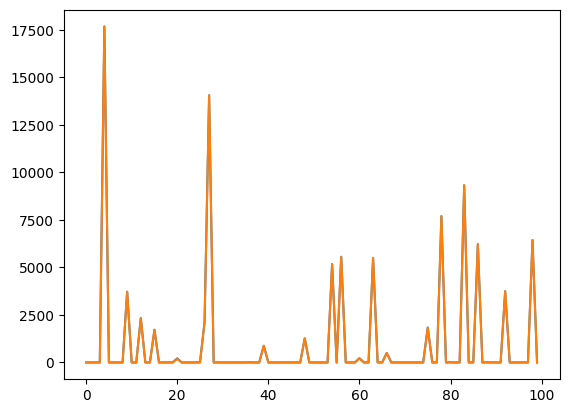

In [195]:
plot(data)

mean_avg_time_spent 90.16556692188571
mean_avg_queue_size 64.2866409632559
mean_max_load 1049.71


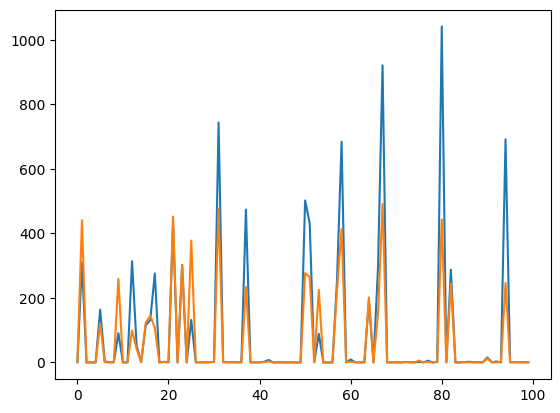

In [113]:
plot(data_1)

# Pierwszy scenariusz

### Identyczne serwery i zadania

#### a) jednostajny wybór serwera

In [60]:
plot(experiment(d_choices=False, scenario='uniform server selection', servers_speed='same'))

TypeError: initialize_servers_speeds() got an unexpected keyword argument 'servers_rate'

#### b) wybór mniej obciążonego z 2 jednostajnie wybranych serwerów

mean_avg_time_spent 2.579543142378132
mean_avg_queue_size 1.2311956517109488
mean_max_load 122.785


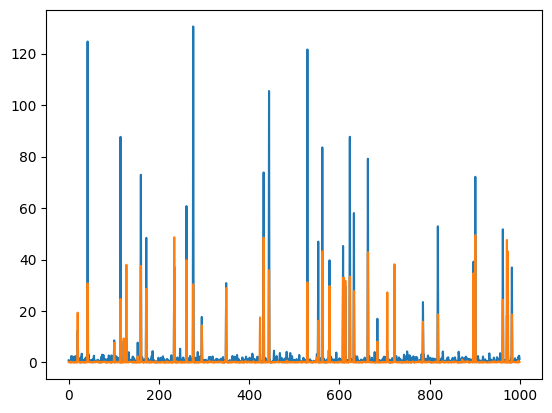

In [ ]:
plot(experiment(d_choices=2, scenario='uniform server selection with power of d-choices', servers_speed='same'))

#### c) wybór mniej obciążonego z d jednostajnie wybranych serwerów

In [ ]:
same_speeds_3_choices = experiment(d_choices=3, scenario='uniform server selection with power of d-choices', servers_speed='same')

mean_avg_time_spent 2.1883936599868594
mean_avg_queue_size 1.0004780104574647


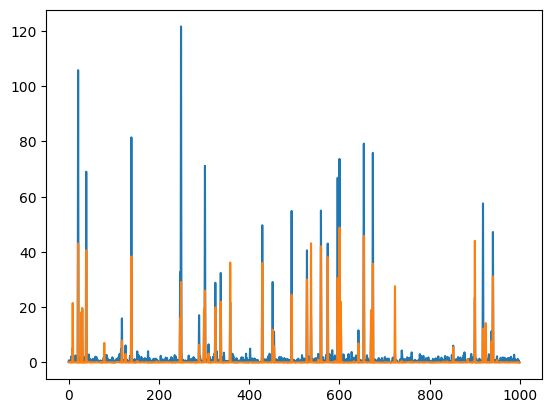

In [ ]:
plot(same_speeds_3_choices)

# Drugi scenariusz

### Serwery o różnej szybkości, takie same zadania

#### a) jednostajny wybór serwera

In [ ]:
different_servers_uniform_choice = experiment(d_choices=False, scenario='uniform server selection', servers_speed='different')

mean_avg_time_spent 2.5721575238612258
mean_avg_queue_size 1.882056464671077


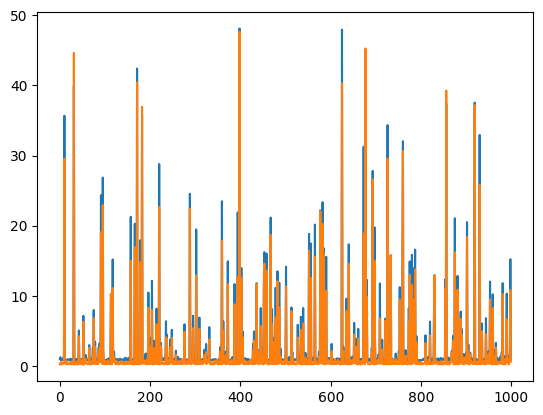

In [ ]:
plot(different_servers_uniform_choice)

#### b) wybór mniej obciążonego z 2 jednostajnie wybranych serwerów

In [ ]:
different_servers_2_choices = experiment(d_choices=2, scenario='uniform server selection with power of d-choices', servers_speed='different')

mean_avg_time_spent 0.7311838693043273
mean_avg_queue_size 0.6153893307721228


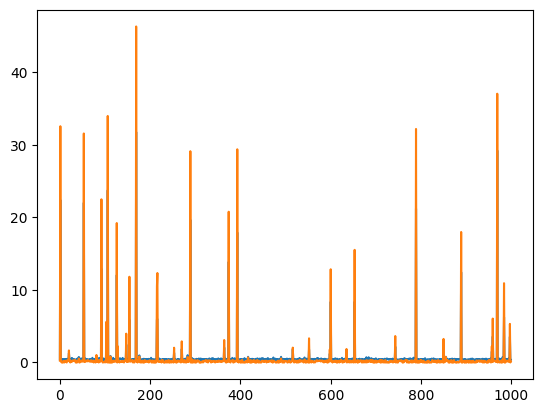

In [ ]:
plot(different_servers_2_choices)

#### c) wybór mniej obciążonego z d jednostajnie wybranych serwerów

mean_avg_time_spent 0.41094670807312256
mean_avg_queue_size 0.20623101064012975


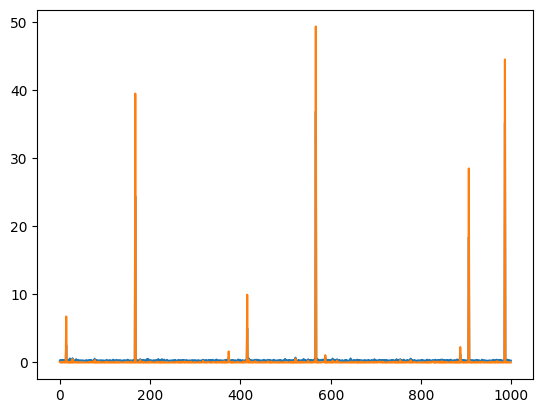

In [ ]:
plot(experiment(d_choices=3, scenario='uniform server selection with power of d-choices', servers_speed='different'))

#### d) wybór mniej obciążonego z 2 niejednostajnie wybranych serwerów

#### e) wybór mniej obciążonego z d niejednostajnie wybranych serwerów

# Trzeci scenariusz

### Serwery o różnej szybkości, różne zadania

#### a) jednostajny wybór serwera

#### b) wybór mniej obciążonego z 2 jednostajnie wybranych serwerów

#### c) wybór mniej obciążonego z d jednostajnie wybranych serwerów

#### d) wybór mniej obciążonego z 2 niejednostajnie wybranych serwerów

#### e) wybór mniej obciążonego z d niejednostajnie wybranych serwerów